# Solving the Lorenz System Using Physics-Informed Neural Networks (PINNs)

## Problem Statement

The **Lorenz system** is a classic example of a 3-variable chaotic ODE system originally derived from simplified convection rolls in the atmosphere. It is defined by

$$
\begin{aligned}
\dot x &= \sigma\,(y - x),\\
\dot y &= x\,(\rho - z) - y,\\
\dot z &= x\,y - \beta\,z,
\end{aligned}
\qquad t \ge 0
$$

Where:  
- \(x(t), y(t), z(t)\) are the state variables.  
- \($\sigma$\), \($\rho$\), and \($\beta$\) are system parameters.  
- We enforce the **initial condition**  
  $$
  (x(0),\,y(0),\,z(0)) = (x_0,\,y_0,\,z_0).
  $$

Typical parameter values for the canonical “Lorenz attractor” are:  
- \($\sigma$ = 10\)  
- \($\rho$ = 28\)  
- \($\beta$ = $\tfrac{8}{3}$\)  

A common choice of initial state is \((x_0,y_0,z_0) = (1,1,1)\).

---

## Chaotic Dynamics

- No closed-form solution exists for arbitrary \(t\).  
- Exhibits **sensitive dependence on initial conditions** (chaos).  
- Trajectories for \($\rho$ > 24.74\) converge to the famous **Lorenz attractor**.

---

## PINN Objective

We approximate each state by a neural network  
\[
(\,\hat x(t;\theta),\;\hat y(t;\theta),\;\hat z(t;\theta)\,)
\]
and train to minimize the combined loss

$$
\mathcal{L}
=
\underbrace{\mathrm{MSE}_{\rm res}}_{\text{ODE residuals}}
\;+\;
\underbrace{\mathrm{MSE}_{\rm ic}}_{\text{initial conditions}}.
$$

- **Residual loss** (enforces the Lorenz ODEs at residual points \(t_i\)):  
  $$
  \mathrm{MSE}_{\rm res}
  = \frac{1}{N_r} \sum_{i=1}^{N_r}
  \Bigl[
    \dot{\hat x}(t_i) - \sigma\bigl(\hat y(t_i)-\hat x(t_i)\bigr)
  \Bigr]^2
  + 
  \Bigl[
    \dot{\hat y}(t_i) - \bigl(\hat x(t_i)\,(\rho-\hat z(t_i)) - \hat y(t_i)\bigr)
  \Bigr]^2
  + 
  \Bigl[
    \dot{\hat z}(t_i) - \bigl(\hat x(t_i)\,\hat y(t_i) - \beta\,\hat z(t_i)\bigr)
  \Bigr]^2.
  $$

- **Initial condition loss**:  
  $$
  \mathrm{MSE}_{\rm ic}
  = (\hat x(0)-x_0)^2
  + (\hat y(0)-y_0)^2
  + (\hat z(0)-z_0)^2.
  $$

---

## Why Use PINNs?

- **Mesh-free, continuous surrogate**: yields smooth \(\hat x(t)\), \(\hat y(t)\), \(\hat z(t)\) for all \(t\).  
- **Physics-aware loss**: directly enforces the ODE system, even in chaotic regimes.  
- **Automatic differentiation**: computes \(\dot{\hat x}\), \(\dot{\hat y}\), \(\dot{\hat z}\) easily.  
- **Flexible sampling**: choose residual points anywhere in \([0,T]\) to capture rapid divergence.

Let’s now define our network architecture, sample residual and IC points, and train the PINN to reproduce the Lorenz attractor trajectories!  


In [107]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt

In [108]:
# Generate RK4 "true" trajectory
def Lorentz_System(state, sigma, rho, beta):
    x, y, z = state
    x_dot = sigma*(y-x)
    y_dot = x*(rho-z) - y
    z_dot = x*y - beta*z

    return np.array([x_dot, y_dot, z_dot])


def rk4(state, dt, sigma, rho, beta):
    k1 = Lorentz_System(state, sigma, rho, beta)
    k2 = Lorentz_System(state + 0.5 * dt * k1, sigma, rho, beta)
    k3 = Lorentz_System(state + 0.5 * dt * k2, sigma, rho, beta)
    k4 = Lorentz_System(state + dt * k3, sigma, rho, beta)

    return state + (dt*((k1 + 2*k2 + 2*k3 + k4)/6.0))

In [109]:
class NeuralNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(1, 50),
            nn.Tanh(),
            nn.Linear(50, 50),
            nn.Tanh(),
            nn.Linear(50, 50),
            nn.Tanh(),
            nn.Linear(50, 3)
        )

        # xavier init
        for m in self.net:
            if isinstance(m, nn.Linear):
                nn.init.xavier_normal_(m.weight)
                nn.init.zeros_(m.bias)

    def forward(self, t):
        t_norm = (2*t - 25.0) / 25.0 
        return self.net(t_norm)

In [110]:
def ode(network, t, sigma, rho, beta):
    t = t.clone().detach().requires_grad_(True)
    out = network(t)      # [N,3]
    x = out[:, 0:1]       
    y = out[:, 1:2]
    z = out[:, 2:3]

    dx_dt = torch.autograd.grad(x, t, grad_outputs=torch.ones_like(x), create_graph=True)[0]
    dy_dt = torch.autograd.grad(y, t, grad_outputs=torch.ones_like(y), create_graph=True)[0]
    dz_dt = torch.autograd.grad(z, t, grad_outputs=torch.ones_like(z), create_graph=True)[0]

    f_x = sigma * (y - x)
    f_y = (x * (rho - z)) - y
    f_z = (x * y) - (beta * z)

    res_x = dx_dt - f_x
    res_y = dy_dt - f_y
    res_z = dz_dt - f_z

    return res_x, res_y, res_z

In [111]:
def loss(network, t, t0, x0, y0, z0, 
         sigma, rho, beta, 
         t_data, x_data, y_data, z_data):
         
    # ODE residual loss
    res_x, res_y, res_z = ode(network, t, sigma, rho, beta)
    MSE_res = torch.mean(res_x**2) + torch.mean(res_y**2) + torch.mean(res_z**2)

    # initial-condition loss
    T0_pred = network(t0)      # [N,3]
    x0_pred = T0_pred[:, 0:1]       
    y0_pred = T0_pred[:, 1:2]
    z0_pred = T0_pred[:, 2:3]
    MSE_ic = torch.mean((x0_pred  - x0)**2) + torch.mean((y0_pred  - y0)**2) + torch.mean((z0_pred  - z0)**2)

    # Data-anchor loss
    P = network(t_data)

    MSE_data = ((P[:,0:1] - x_data).pow(2).mean()
              + (P[:,1:2] - y_data).pow(2).mean()
              + (P[:,2:3] - z_data).pow(2).mean())

    λ_ic, λ_data = 100.0, 1.0

    return MSE_res + (λ_ic * MSE_ic) + (λ_data * MSE_data)

In [112]:
def train(network, t, t0, x0, y0, z0, 
          sigma, rho, beta, 
          t_data, x_data, y_data, z_data,
          epochs, lr = 1e-3):

    optimizer = torch.optim.Adam(network.parameters(), lr=lr)
    loss_list = []

    for epoch in range(1, epochs + 1):
        optimizer.zero_grad()
        loss_value = loss(network, t, t0, x0, y0, z0,
                 sigma, rho, beta,
                 t_data, x_data, y_data, z_data)
        loss_list.append(loss_value.item())
        loss_value.backward()
        optimizer.step()

        if epoch % 100 == 0 or epoch == 1:
            print(f"Epoch {epoch}/{epochs} — Loss: {loss_value.item():.3e}")

    return loss_list

In [113]:
# Collocation points in the interior
t_train = torch.linspace(0, 25, 5000).reshape(-1,1)

# Model Parameters
sigma = 10.0
rho   = 28.0
beta  = 8.0/3.0

t0 = torch.tensor([[0.0]], dtype=torch.float32)
x0 = torch.tensor([[1.0]], dtype=torch.float32)
y0 = torch.tensor([[1.0]], dtype=torch.float32)
z0 = torch.tensor([[1.0]], dtype=torch.float32)

# Training hyperparameters
epochs = 5000
lr =  5e-4

In [114]:
# Generating the RK4 "true" trajectory
dt = 0.01
N = 2500
traj = np.zeros((N+1, 3))
s = np.array([1.0,1.0,1.0])
traj[0] = s

for i in range(N):
    s = rk4(s, dt, sigma, rho, beta)
    traj[i+1] = s

t_np = np.linspace(0, 25, N+1).reshape(-1,1).astype(np.float32)

N_data = 10
idx = np.random.choice(N+1, N_data, replace=False)
t_data_np = t_np[idx]
x_data_np = traj[idx,0:1].astype(np.float32)
y_data_np = traj[idx,1:2].astype(np.float32)
z_data_np = traj[idx,2:3].astype(np.float32)

t_data = torch.from_numpy(t_data_np)
x_data = torch.from_numpy(x_data_np)
y_data = torch.from_numpy(y_data_np)
z_data = torch.from_numpy(z_data_np)

In [115]:
#  Instantiate and train the model
model = NeuralNetwork()
loss_list = train(model, t_train, t0, x0, y0, z0, 
          sigma, rho, beta, 
          t_data, x_data, y_data, z_data,
          epochs, lr = lr)

Epoch 1/5000 — Loss: 1.002e+03
Epoch 100/5000 — Loss: 6.646e+02
Epoch 200/5000 — Loss: 6.353e+02
Epoch 300/5000 — Loss: 6.127e+02
Epoch 400/5000 — Loss: 5.876e+02
Epoch 500/5000 — Loss: 5.760e+02
Epoch 600/5000 — Loss: 5.713e+02
Epoch 700/5000 — Loss: 5.689e+02
Epoch 800/5000 — Loss: 5.673e+02
Epoch 900/5000 — Loss: 5.661e+02
Epoch 1000/5000 — Loss: 5.651e+02
Epoch 1100/5000 — Loss: 5.642e+02
Epoch 1200/5000 — Loss: 5.634e+02
Epoch 1300/5000 — Loss: 5.626e+02
Epoch 1400/5000 — Loss: 5.617e+02
Epoch 1500/5000 — Loss: 5.610e+02
Epoch 1600/5000 — Loss: 5.603e+02
Epoch 1700/5000 — Loss: 5.597e+02
Epoch 1800/5000 — Loss: 5.591e+02
Epoch 1900/5000 — Loss: 5.585e+02
Epoch 2000/5000 — Loss: 5.580e+02
Epoch 2100/5000 — Loss: 5.575e+02
Epoch 2200/5000 — Loss: 5.570e+02
Epoch 2300/5000 — Loss: 5.566e+02
Epoch 2400/5000 — Loss: 5.562e+02
Epoch 2500/5000 — Loss: 5.558e+02
Epoch 2600/5000 — Loss: 5.554e+02
Epoch 2700/5000 — Loss: 5.550e+02
Epoch 2800/5000 — Loss: 5.545e+02
Epoch 2900/5000 — Loss: 5.

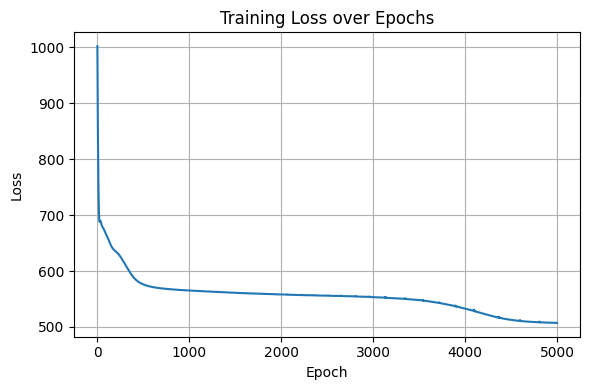

In [116]:
plt.figure(figsize=(6,4))
plt.plot(range(1, epochs+1), loss_list)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss over Epochs')
plt.grid(True)
plt.tight_layout()
plt.show()

### Testing the model

In [117]:
t_np = np.linspace(0, N*dt, N+1) 
t_test_np = t_np.reshape(-1,1).astype(np.float32)
t_test = torch.from_numpy(t_test_np)  # shape [N+1,1]

model.eval()

with torch.no_grad():
    t_pred = model(t_test)

x_pred = t_pred[:, 0:1]       
y_pred = t_pred[:, 1:2]
z_pred = t_pred[:, 2:3]

x_pred_np = x_pred.cpu().numpy()
y_pred_np = y_pred.cpu().numpy()
z_pred_np = z_pred.cpu().numpy()

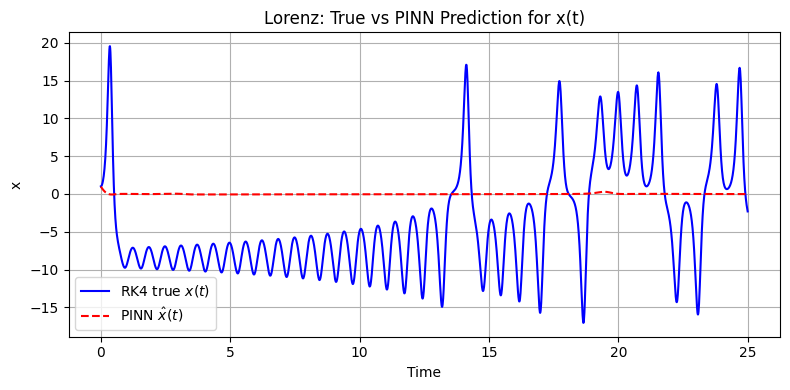

In [119]:
plt.figure(figsize=(8,4))
plt.plot(t_np, traj[:, 0], 'b-', label='RK4 true $x(t)$')
plt.plot(t_np, x_pred_np, 'r--', label='PINN $\\hat x(t)$')
plt.xlabel('Time')
plt.ylabel('x')
plt.title('Lorenz: True vs PINN Prediction for x(t)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

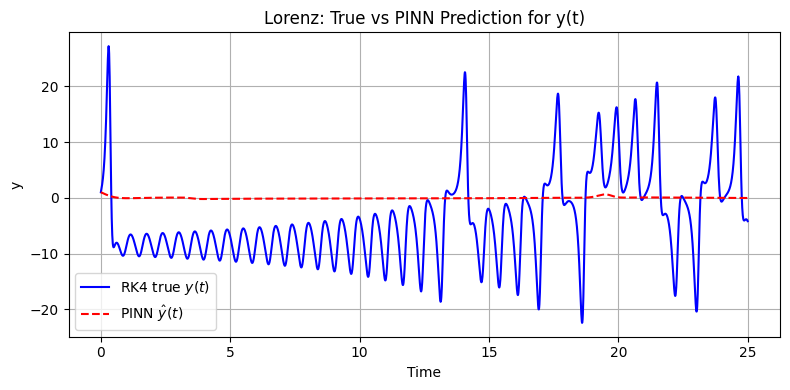

In [120]:
plt.figure(figsize=(8,4))
plt.plot(t_np, traj[:, 1], 'b-', label='RK4 true $y(t)$')
plt.plot(t_np, y_pred_np, 'r--', label='PINN $\\hat y(t)$')
plt.xlabel('Time')
plt.ylabel('y')
plt.title('Lorenz: True vs PINN Prediction for y(t)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

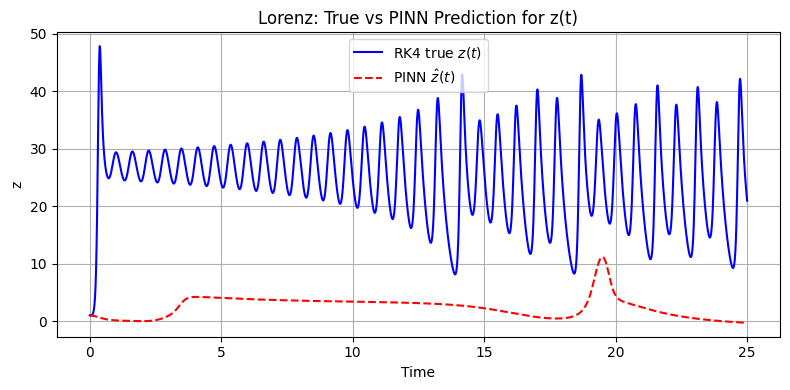

In [121]:
plt.figure(figsize=(8,4))
plt.plot(t_np, traj[:, 2], 'b-', label='RK4 true $z(t)$')
plt.plot(t_np, z_pred_np, 'r--', label='PINN $\\hat z(t)$')
plt.xlabel('Time')
plt.ylabel('z')
plt.title('Lorenz: True vs PINN Prediction for z(t)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()